In [5]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

def simple_autoencoder():
    autoencoder = Sequential([
        # Encoder
        Input(shape=(1000, 1)),
        Flatten(),
        Dense(32, activation='relu'),

        # Bottleneck
        Dense(5, activation='relu'),

        # Decoder
        Dense(32, activation='relu'),
        Dense(1000, activation='tanh'),
        Reshape((1000, 1))
    ])

    return autoencoder

In [6]:
DIR = "../data/Raw/logRaws/"

NUM_SAMPLES = 2662
NUM_FEATURES = 1
NUM_FRAMES = 1000

file_names = os.listdir(DIR)
input_array = np.empty((NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES))

# prepare data
def read_files(DIR):
    all_files = os.listdir(DIR)

    input_data = np.empty((0, 1), float)

    for file in all_files:
        file_path = os.path.join(DIR, file)
        df = pd.read_csv(file_path, usecols=[1, 16], header=None)
        if df.shape[0] < 999:
            continue

        df.columns = ['frame', 'accel_x']
        df_input = df[['accel_x']]
        df_input = df_input.astype('float32')

        input_data = np.append(input_data, df_input, axis=0)
    input_data = input_data.reshape(NUM_SAMPLES, NUM_FRAMES, NUM_FEATURES)

    # divide by 16 to normalize
    input_data = input_data / 16

    return input_data

input_data = read_files(DIR)

input_data.shape


(2662, 1000, 1)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(input_data, test_size=0.2, random_state=42)

# compile autoencoder
autoencoder = simple_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# train autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, X_test))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                32032     
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
 dense_6 (Dense)             (None, 32)                192       
                                                                 
 dense_7 (Dense)             (None, 1000)              33000     
                                                                 
 reshape_1 (Reshape)         (None, 1000, 1)           0         
                                                                 
Total params: 65389 (255.43 KB)
Trainable params: 6538

17/17 [==============================] - 0s 6ms/step


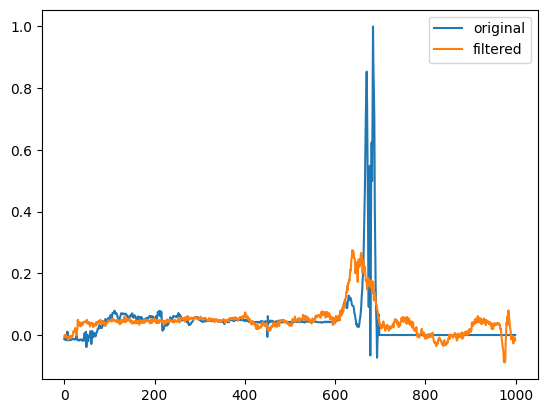

In [8]:
import matplotlib.pyplot as plt

filtered_data = autoencoder.predict(X_test)

INDEX = 1

plt.plot(X_test[INDEX])
plt.plot(filtered_data[INDEX])
plt.legend(['original', 'filtered'])
plt.show()
